https://blog.paperspace.com/object-localization-using-pytorch-1/  
 https://blog.paperspace.com/object-localization-pytorch-2/

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np

from sklearn.model_selection import train_test_split #machine learing package: in genreal for diff learings

import matplotlib.pyplot as plt
import cv2
import random
import os

from PIL import Image

import pandas as pd
from xml.dom import minidom
import csv

Altering "def extract_xml_contents annot_directory, image_dir)" function to extract content from our matlab content. We are returning the filename, width + height of the images, classification number, and the corner value for our bounding boxes. We dont have file name so we just returned the image array

In [ ]:
def extract_contents(image, x, y):

        # Get the height and width for our image (80x80)
        height, width = 80, 80

        # Get the bounding box corner co-ordinate
        x_corner = x-3
        y_corner = y-3
        class_name = 'Tumor' #Not needed
        class_num = 1

        file = image

        # Return the extracted attributes
        return file, width, height, class_num, x_corner, y_corner


In [ ]:
num_to_labels= {1:'Tumor'}

No need to convert XML files to CSV so we can just change the "def xml_to_csv():" function to a new one that stores each images attributes into a dataframe


In [ ]:
import matplotlib.pyplot as plt
import cv2
import random
import os
import numpy as np
import csv
import scipy.io

In [ ]:
def images_dataframe():
  mat_file = '/content/drive/MyDrive/Research /MATH 499 S24/Data/SampleDataSetSize80x80Bright.mat'
  data = scipy.io.loadmat(mat_file)

  # List containing all our attributes regarding each image
  image_list = []

  # Extract image data and tumor locations
  images = data['tumorImageArray']
  x_locs = data['xLocArray'][0]
  y_locs = data['yLocArray'][0]

  # We loop though each class and its labels one by one to preprocess and augment
  for mat, image_num in zip(x_locs, y_locs):
      # Get Attributes for each image
      value = extract_contents(images[mat], x_locs[mat], y_locs[mat])

      # Append the attributes to the mat_list
      image_list.append(value)

  # Columns for Pandas DataFrame
  column_name = ['imagefile', 'width', 'height', 'class_num', 'x_corner', 'y_corner']

  # Create the DataFrame from mat_list
  image_df = pd.DataFrame(image_list, columns=column_name)

  # Return the dataframe
  return image_df

# The Class we will use for our training
classes_list = sorted(['Tumor']) #Line that the question is referring to

# Run the function to convert all the images to a Pandas DataFrame
labels_df = images_dataframe()

Normalizing Our Data


In [ ]:
def preprocess_dataset():
  # Lists that will contain the whole dataset
  labels = []
  boxes = []
  img_list = []

  h = 80
  w = 80

  mat_file = '/content/drive/MyDrive/Research /MATH 499 S24/Data/SampleDataSetSize80x80Bright.mat'
  data = scipy.io.loadmat(mat_file)
  images = data['tumorImageArray']
  normalize = np.amax(images)

  for i in range(len(labels_df)):
    labels.append(labels_df.iloc[i,3]) #classification label
    arr = [(labels_df.iloc[i,4])/80, (labels_df.iloc[i,5])/80] #bounding box Question
    boxes.append(arr)
    img_path = labels_df.iloc[i,0] #image

    # Normalize the image data to [0, 1] range
    img = img_path/normalize #Question

    # Append it to the list of images
    img_list.append(img)

  return labels, boxes, img_list

In [ ]:
# Get Augmented images and bounding boxes
labels, boxes, img_list = preprocess_dataset()

# Now we need to shuffle the data, so zip all lists and shuffle
combined_list = list(zip(img_list, boxes, labels))
random.shuffle(combined_list)

# Extract back the contents of each list
img_list, boxes, labels = zip(*combined_list)

In [ ]:
def create_bb(bb, image_number): # Creating red box
    height = 3.5
    width = 3.5
    return plt.Rectangle(bb, width, height, color = 'red', fill=False, lw=1)

def show_corner_bb(im, image_number, bb): # Creating the patch
    plt.imshow(im,cmap='gray')
    plt.gca().add_patch(create_bb(bb,image_number))

Return 4 sample images




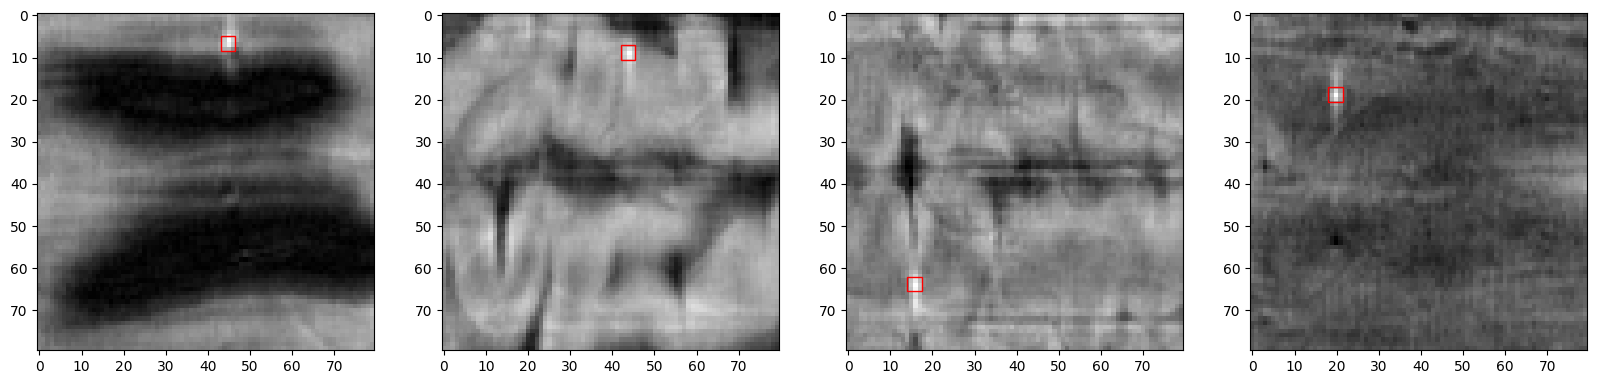

In [ ]:
# Create a Matplotlib figure
plt.figure(figsize=(20,20));

# Generate a random sample of images each time the cell is run
random_range = random.sample(range(1, len(img_list)), 4)

itr=0
for  i in random_range:
    itr=itr+1
    # Bounding box of each image
    a1, b1 = boxes[i];
    img_size = 80

    # Rescaling the boundig box values to match the image size
    x1 = a1 * img_size
    y1 = b1 * img_size

    bb= [x1,y1]

    #print(i)
    #print(a1,b1)
    #print(bb)

    # The image to visualize
    image = img_list[i]

    plt.subplot(1, 4, itr);
    # Draw bounding boxes on the image
    show_corner_bb(image,i,bb)

    # Clip the values to 0-1 and draw the sample of images
    #img = np.clip(img_list[i], 0, 1)
    #plt.subplot(1, 4, itr); #Just plot 4 images in our case
    #plt.imshow(img);
    #plt.axis('off');

In [ ]:
# Split the data of images, labels and their annotations
train_images, val_images, train_labels, \
val_labels, train_boxes, val_boxes = train_test_split( np.array(img_list),
                np.array(labels), np.array(boxes), test_size = 0.2,
                random_state = 43)

print('Training Images Count: {}, Validation Images Count: {}'.format(
    len(train_images), len(val_images) ))

Training Images Count: 640, Validation Images Count: 160


In [ ]:
from PIL import Image
import torch
import torchvision
from torchvision.transforms import ToTensor
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import os
import pickle
import random
import time

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device


device(type='cuda')

In [ ]:
class Dataset():
    def __init__(self, train_images, train_labels, train_boxes):
        self.images = train_images
        self.labels = train_labels
        self.boxes = train_boxes

    def __len__(self):
        return len(self.labels)
    #def __len__(self):
        #return len(self.images)

    # To return x,y values in each iteration over dataloader as batches.

    def __getitem__(self, idx):
        return (self.images[idx],
              self.labels[idx],
              self.boxes[idx])

# Inheriting from Dataset class

class ValDataset(Dataset):

    def __init__(self, val_images, val_labels, val_boxes):

        self.images = val_images
        self.labels = val_labels
        self.boxes = val_boxes


In [ ]:
#dataset = Dataset(train_images, train_labels, train_boxes)
#valdataset = ValDataset(val_images, val_labels, val_boxes)
# Convert NumPy arrays to floats using astype
dataset = Dataset(train_images.astype(np.float32), train_labels.astype(np.float32), train_boxes.astype(np.float32))
valdataset = ValDataset(val_images.astype(np.float32), val_labels.astype(np.float32), val_boxes.astype(np.float32))


In [ ]:
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        # Define convolutional layers
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=3, kernel_size=2)
        self.conv2 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=2)
        self.conv3 = nn.Conv2d(in_channels=6, out_channels=12, kernel_size=2)
        self.conv4 = nn.Conv2d(in_channels=12, out_channels=24, kernel_size=2)
        self.conv5 = nn.Conv2d(in_channels=24, out_channels=48, kernel_size=2)

        # Connecting CNN outputs with Fully Connected layers for classification
        self.class_fc1 = nn.Linear(in_features=48, out_features=24)
        self.class_fc2 = nn.Linear(in_features=24, out_features=12)
        self.class_out = nn.Linear(in_features=12, out_features=2)

        # Connecting CNN outputs with Fully Connected layers for bounding box
        self.box_fc1 = nn.Linear(in_features=48, out_features=24)
        self.box_fc2 = nn.Linear(in_features=24, out_features=12)
        self.box_out = nn.Linear(in_features=12, out_features=2)

    def forward(self, t):
        t = self.conv1(t)
        t = F.relu(t)
        t = F.max_pool2d(t, kernel_size=2, stride=2)

        t = self.conv2(t)
        t = F.relu(t)
        t = F.max_pool2d(t, kernel_size=2, stride=2)

        t = self.conv3(t)
        t = F.relu(t)
        t = F.max_pool2d(t, kernel_size=2, stride=2)

        t = self.conv4(t)
        t = F.relu(t)
        t = F.max_pool2d(t, kernel_size=2, stride=2)

        t = self.conv5(t)
        t = F.relu(t)
        t = F.avg_pool2d(t, kernel_size=2, stride=2)

        t = torch.flatten(t, start_dim=1)
        t=torch.transpose(t,0,1)
        #print(t.size())

        class_t = self.class_fc1(t)
        class_t = F.relu(class_t)

        class_t = self.class_fc2(class_t)
        class_t = F.relu(class_t)

        class_t = F.softmax(self.class_out(class_t), dim=1)

        box_t = self.box_fc1(t)
        box_t = F.relu(box_t)

        box_t = self.box_fc2(box_t)
        box_t = F.relu(box_t)

        box_t = self.box_out(box_t)
        box_t = F.sigmoid(box_t)

        return [class_t, box_t]


In [ ]:
model = Network()
model = model.to(device)
model

Network(
  (conv1): Conv2d(1, 3, kernel_size=(2, 2), stride=(1, 1))
  (conv2): Conv2d(3, 6, kernel_size=(2, 2), stride=(1, 1))
  (conv3): Conv2d(6, 12, kernel_size=(2, 2), stride=(1, 1))
  (conv4): Conv2d(12, 24, kernel_size=(2, 2), stride=(1, 1))
  (conv5): Conv2d(24, 48, kernel_size=(2, 2), stride=(1, 1))
  (class_fc1): Linear(in_features=48, out_features=24, bias=True)
  (class_fc2): Linear(in_features=24, out_features=12, bias=True)
  (class_out): Linear(in_features=12, out_features=2, bias=True)
  (box_fc1): Linear(in_features=48, out_features=24, bias=True)
  (box_fc2): Linear(in_features=24, out_features=12, bias=True)
  (box_out): Linear(in_features=12, out_features=2, bias=True)
)

In [ ]:
def get_num_correct(preds, labels):
    return torch.round(preds).argmax(dim=1).eq(labels).sum().item()

In [ ]:
dataloader = torch.utils.data.DataLoader( #We dont have to do this
       dataset, batch_size=1, shuffle=True)
valdataloader = torch.utils.data.DataLoader(
       valdataset, batch_size=1, shuffle=True)

In [ ]:
def train(model):
    # Defining the optimizer
    optimizer = optim.Adam(model.parameters(),lr = 0.01)
    num_of_epochs = 1000
    epochs = []
    losses = []
    # Creating a directory for storing models
    # os.mkdir('models')
    for epoch in range(num_of_epochs):
        tot_loss = 0
        tot_correct = 0
        train_start = time.time()
        model.train()
        for batch, (x, y, z) in enumerate(dataloader):
        	# Converting data from cpu to GPU if available to improve speed
            x, y, z = x.to(device).float(), y.to(device).long(), z.to(device).float()
            #print(x)
            #print(y)
            #print(z)
            # Sets the gradients of all optimized tensors to zero
            optimizer.zero_grad()
            [y_pred,z_pred]= model(x)
            # Compute loss (here CrossEntropyLoss)
            class_loss = F.cross_entropy(y_pred, y)
            box_loss = F.mse_loss(z_pred, z)
            (box_loss + class_loss).backward()
            # class_loss.backward()
            optimizer.step()
            print("Train batch:", batch+1, " epoch: ", epoch, " ",
                  (time.time()-train_start)/60, end='\r')

        model.eval()
        for batch, (x, y,z) in enumerate(valdataloader):
        	# Converting data from cpu to GPU if available to improve speed
            x,y,z = x.to(device).float(),y.to(device).long(),z.to(device).float()
            # Sets the gradients of all optimized tensors to zero
            optimizer.zero_grad()
            with torch.no_grad():
                [y_pred,z_pred]= model(x)

                # Compute loss (here CrossEntropyLoss)
                class_loss = F.cross_entropy(y_pred, y)
                box_loss = F.mse_loss(z_pred, z)
                # Compute loss (here CrossEntropyLoss)

            tot_loss += (class_loss.item() + box_loss.item())
            tot_correct += get_num_correct(y_pred, y)
            print("Test batch:", batch+1, " epoch: ", epoch, " ",
                  (time.time()-train_start)/60, end='\r')
        epochs.append(epoch)
        losses.append(tot_loss)
        print("Epoch", epoch, "Accuracy", (tot_correct)/1.6, "loss:",
              tot_loss, " time: ", (time.time()-train_start)/60, " mins")
        torch.save(model.state_dict(), "model_ep"+str(epoch+1)+".pth")

In [ ]:
train(model)

Epoch 0 Accuracy 100.0 loss: 59.50477234227583  time:  0.0828423301378886  mins
Epoch 1 Accuracy 100.0 loss: 59.48695678357035  time:  0.08542654911677043  mins
Epoch 2 Accuracy 100.0 loss: 59.56209254171699  time:  0.09001063903172811  mins
Epoch 3 Accuracy 100.0 loss: 59.518613705877215  time:  0.08070404132207235  mins
Epoch 4 Accuracy 100.0 loss: 59.52571723330766  time:  0.09366190830866496  mins
Epoch 5 Accuracy 100.0 loss: 59.496920477133244  time:  0.08907400369644165  mins
Epoch 6 Accuracy 100.0 loss: 59.535868908744305  time:  0.09228011767069498  mins
Epoch 7 Accuracy 100.0 loss: 59.57526150299236  time:  0.08871720631917318  mins
Epoch 8 Accuracy 100.0 loss: 59.457664768211544  time:  0.08353983561197917  mins
Epoch 9 Accuracy 100.0 loss: 59.44171586725861  time:  0.09435138702392579  mins
Epoch 10 Accuracy 100.0 loss: 59.57009399193339  time:  0.08877241611480713  mins
Epoch 11 Accuracy 100.0 loss: 59.47182489838451  time:  0.08133809169133505  mins
Epoch 12 Accuracy 100.0

In [ ]:
def postprocess(image, results):

    # Split the results into class probabilities and box coordinates
    [class_probs, bounding_box] = results

    # First let's get the class label

    # The index of class with the highest confidence is our target class
    class_index = torch.argmax(class_probs) #Tensor

    # Use this index to get the class name.
    class_label = num_to_labels[class_index.item()] #Key cannot be a tensor

    # Now you can extract the bounding box too.

    # Get the height and width of the actual image
    h, w = 80,80

    # Extract the Coordinates
    x1, y1 = bounding_box[0]

    # # Convert the coordinates from relative (i.e. 0-1) to actual values
    x1 = int(w * x1)
    y1 = int(h * y1)

    # return the lable and coordinates
    return class_label, (x1,y1), torch.max(class_probs)*100


In [ ]:
def postprocess(image, results):

    # Split the results into class probabilities and box coordinates
    [class_probs, bounding_box] = results #These are tensors

    # First let's get the class label
    # The index of class with the highest confidence is our target class
    class_index = torch.argmax(class_probs) #Tensor

    # Use this index to get the class name.
    class_label = num_to_labels[class_index.item()] #Key cannot be a tensor

    # Now you can extract the bounding box too.

    # Get the height and width of the actual image
    h, w = 80,80

    # Extract the Coordinates
    x1, y1 = bounding_box[0]

    # # Convert the coordinates from relative (i.e. 0-1) to actual values
    x1 = int(w * x1)
    y1 = int(h * y1)

    # return the lable and coordinates
    return class_label, (x1,y1), torch.max(class_probs)*100


In [ ]:
# We will use this function to make prediction on images.
def predict(image, index, scale = 0.5):
  model = Network()
  model = model.to(device)
  #model.load_state_dict(torch.load(image)) # we might not need this
  model.eval()

  img_array = image
  # # Before we can make a prediction we need to preprocess the image.
  processed_image = img_array/np.amax(img_array) #Normalizing

  processed_image = processed_image.reshape((1, 80, 80)) #Reshaping to 3D

  processed_image = torch.from_numpy(processed_image).to(device).float()

  result = model(processed_image)

  # After postprocessing, we can easily use our results
  label, (x1, y1), confidence = postprocess(image, result) #Error

  # Now annotate the image
  show_corner_bb(image, index, (x1,y1))

  # Show the Image with matplotlib
  #plt.figure(figsize=(10,10))
  #plt.imshow(image[:,:,::-1])

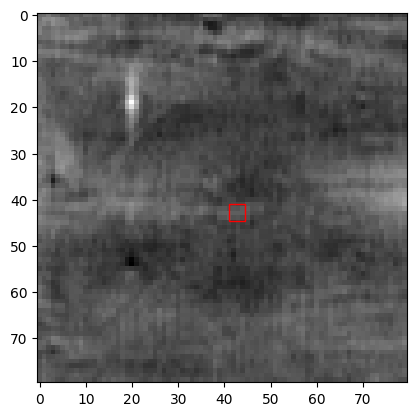

In [ ]:
image = val_images[159]
predict(image,159)